In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Dropout
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
train_seq = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
train_lab = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
test_seq = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
val_lab = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/validation_labels.csv")
val_seq = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv")
sub_sample = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/sample_submission.csv")



In [3]:
dfs = [train_seq, train_lab, test_seq, val_lab, val_seq, sub_sample]

for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} Info:")
    print(df.info())
    print("\n" + "="*50 + "\n")


DataFrame 1 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   target_id        12 non-null     object
 1   sequence         12 non-null     object
 2   temporal_cutoff  12 non-null     object
 3   description      12 non-null     object
 4   all_sequences    12 non-null     object
dtypes: object(5)
memory usage: 608.0+ bytes
None


DataFrame 2 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137095 entries, 0 to 137094
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ID       137095 non-null  object 
 1   resname  137095 non-null  object 
 2   resid    137095 non-null  int64  
 3   x_1      130950 non-null  float64
 4   y_1      130950 non-null  float64
 5   z_1      130950 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 6.3+ MB
None


Data

In [4]:
train_lab.isnull().sum()

ID            0
resname       0
resid         0
x_1        6145
y_1        6145
z_1        6145
dtype: int64

In [5]:
train_lab.head()

,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A_5,G,5,1.827,-20.136000,11.793


In [6]:
for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} Info:")
    print(df.head())
    print("\n" + "="*50 + "\n")


DataFrame 1 Info:
  target_id                                           sequence  \
0     R1107  GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...   
1     R1108  GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...   
2     R1116  CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...   
3   R1117v2                     UUGGGUUCCCUCACCCCAAUCAUAAAAAGG   
4     R1126  GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUU...   

  temporal_cutoff                                        description  \
0      2022-05-28  CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...   
1      2022-05-27  CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...   
2      2022-06-04  Cloverleaf RNA\nPoliovirus\nCrystal Structure ...   
3      2022-06-03  PreQ1 class I type III riboswitch\nK. pneumoni...   
4      2022-06-11  Traptamer\nSynthetic\nAdditional Information: ...   

                                       all_sequences  
0  >7QR4_1|Chain A|U1 small nuclear ribonucleopro...  
1  >7QR3_1|Chains A, B|U1 small nuclear ri

In [7]:
for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} Missing Values:")
    print(df.isnull().sum())  # Check for missing values
    print("\n" + "="*50 + "\n")


DataFrame 1 Missing Values:
target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


DataFrame 2 Missing Values:
ID            0
resname       0
resid         0
x_1        6145
y_1        6145
z_1        6145
dtype: int64


DataFrame 3 Missing Values:
target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


DataFrame 4 Missing Values:
ID         0
resname    0
resid      0
x_1        0
y_1        0
          ..
y_39       0
z_39       0
x_40       0
y_40       0
z_40       0
Length: 123, dtype: int64


DataFrame 5 Missing Values:
target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


DataFrame 6 Missing Values:
ID         0
resname    0
resid      0
x_1        0
y_1        0
z_1        0
x_2        0
y_2        0
z_2        0
x_3        0
y_3        0
z_3        0
x_4        0
y_4        0
z_4     

In [8]:
train_lab[['x_1', 'y_1', 'z_1']] = train_lab[['x_1', 'y_1', 'z_1']].fillna(train_lab[['x_1', 'y_1', 'z_1']].median())

In [9]:
for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} Missing Values:")
    print(df.isnull().sum())  # Check for missing values
    print("\n" + "="*50 + "\n")

DataFrame 1 Missing Values:
target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


DataFrame 2 Missing Values:
ID         0
resname    0
resid      0
x_1        0
y_1        0
z_1        0
dtype: int64


DataFrame 3 Missing Values:
target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


DataFrame 4 Missing Values:
ID         0
resname    0
resid      0
x_1        0
y_1        0
          ..
y_39       0
z_39       0
x_40       0
y_40       0
z_40       0
Length: 123, dtype: int64


DataFrame 5 Missing Values:
target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


DataFrame 6 Missing Values:
ID         0
resname    0
resid      0
x_1        0
y_1        0
z_1        0
x_2        0
y_2        0
z_2        0
x_3        0
y_3        0
z_3        0
x_4        0
y_4        0
z_4        0
x_5        0


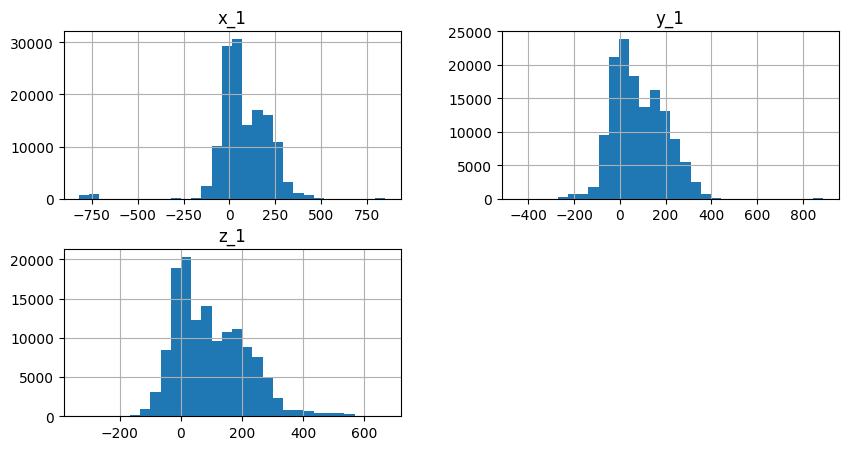

In [10]:
train_lab[['x_1', 'y_1', 'z_1']].hist(bins=30, figsize=(10, 5))
plt.show()

In [11]:
for i, df in enumerate(dfs):
    print(f"DataFrame {i+1} Duplicates:")
    print(df.duplicated().sum())  
    print("\n" + "="*50 + "\n")

DataFrame 1 Duplicates:
0


DataFrame 2 Duplicates:
0


DataFrame 3 Duplicates:
0


DataFrame 4 Duplicates:
0


DataFrame 5 Duplicates:
0


DataFrame 6 Duplicates:
0




In [12]:
from collections import Counter

def kmer_freq(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return Counter(kmers)

train_seq['kmer_features'] = train_seq['sequence'].apply(lambda x: kmer_freq(x, k=3))


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = train_lab.drop(columns=['ID', 'resname', 'resid'])
y = train_lab[['x_1', 'y_1', 'z_1']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, predictions)}')


MSE: 1.9680287207608675


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3)  # Predicting x, y, z coordinates
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3428/3428 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1325.8016 - val_loss: 1206.6256
Epoch 2/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 214.0548 - val_loss: 1623.4122
Epoch 3/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 157.7924 - val_loss: 1747.1908
Epoch 4/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 124.6985 - val_loss: 1824.6478
Epoch 5/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 111.3700 - val_loss: 1878.5448
Epoch 6/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 95.4058 - val_loss: 1961.7075
Epoch 7/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 81.9102 - val_loss: 2098.4185
Epoch 8/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 68.8029 - val_loss: 2014.3760
Epoch 9/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 64.8103 - val_loss: 1997.8972
Epoch 10/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 56.4774 - val_loss: 2021.2845
Epoch 11/50
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 51.8137 - val_loss: 2